# Практическая работа №6: Кластерный анализ. Метод k-средних

Выполнил студент гр. 9372 Романов Максим, вариант 18.

## Цель работы
Освоение основных понятий и некоторых методов кластерного анализа,
в частности, метода k-means.



## Основные теоретические положения
Основные теоретические положения

## Постановка задачи
Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в практической работе №4). Выполнить разбиение исходного множества объектов на конечное число подмножеств
(кластеров) с использованием метода k-means. Полученные результаты
содержательно проинтерпретировать.


## Порядок выполнения работы
1. Нормализовать множество точек из предыдущего раздела, отобразить полученное множество.
2. Определить «грубую» верхнюю оценку количества кластеров.
3. Реализовать алгоритм k-means. Отобразить полученные кластеры,
выделить каждый кластер разным цветом, отметить центроиды.
1
4. Реализовать алгоритмы k-medians (для нечётных вариантов) и kmedoids (для чётных вариантов). Отобразить полученные кластеры, выделить каждый кластер разным цветом, отметить центроиды.
5. С помощью метода локтя и/или метода силуэтов выявить для каждого метода оптимальное количество кластеров.
6. На основании оценки качества разбиения определить наилучший
метод кластеризации.
7. Сравнить методы. Сделать выводы.
8. Реализовать модификацию k-means++. Объяснить её приемущества. Сравнить с обычным методом k-means.

## Выполнение работы

Подготовительная часть

In [ ]:
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:

sample <- read.csv('./sample_data/Statanal_Romanov_2.csv', sep = ";")
x_set <- sample$birth
y_set <- sample$death
sample_cardinality <- length(x_set)

x_sorted_set <- sort(x_set)
x_descrete_series <- data.frame(
  intervals = unique(x_sorted_set),
  abs_freqs = as.vector(table(x_sorted_set))
)
x_descrete_series$rel_freqs = as.vector(prop.table(x_descrete_series$abs_freqs))
y_sorted_set <- sort(y_set)
y_descrete_series <- data.frame(
  intervals = unique(y_sorted_set),
  abs_freqs = as.vector(table(y_sorted_set))
)
y_descrete_series$rel_freqs = as.vector(prop.table(y_descrete_series$abs_freqs))
x_mean <- mean(x_set)
y_mean <- mean(y_set)
x_dispersion <- sum((x_set - x_mean)^ 2) / sample_cardinality
y_dispersion <- sum((y_set - y_mean)^ 2) / sample_cardinality
x_corrected_dispersion <- sample_cardinality * x_dispersion / (sample_cardinality - 1)
y_corrected_dispersion <- sample_cardinality * y_dispersion / (sample_cardinality - 1)
x_std <- sqrt(x_dispersion)
y_std <- sqrt(y_dispersion)
x_corrected_std <- sqrt(x_corrected_dispersion)
y_corrected_std <- sqrt(y_corrected_dispersion)

two_dim_sample <- data.frame(
  x = x_set,
  y = y_set
)

points <- matrix(
  c(two_dim_sample$x, two_dim_sample$y),
  ncol = 2
)



### 1. Нормализуем множество точек из предыдущего раздела, отобразим полученное множество.


[1] 0.2265871 0.2882879

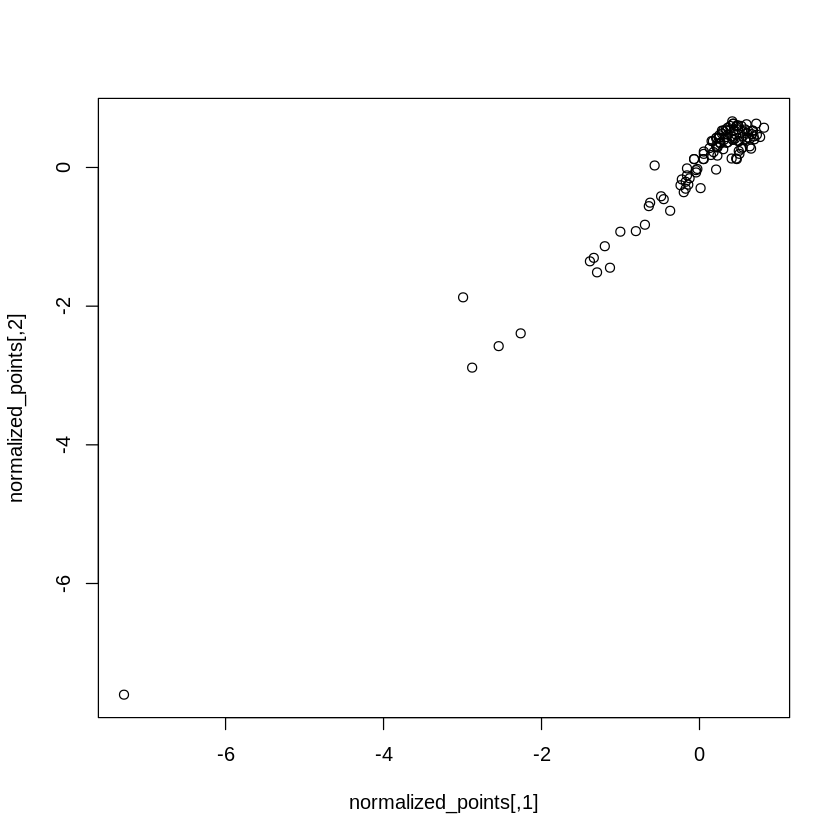

In [ ]:
normalized_points <- points
normalized_points[,1] <- (normalized_points[,1] - x_mean) / x_corrected_std
normalized_points[,2] <- (normalized_points[,2] - y_mean) / y_corrected_std

plot(normalized_points)
as.vector(normalized_points[1,])

### 2. Определим «грубую» верхнюю оценку количества кластеров.



In [ ]:
k_rough <- floor(sqrt(sample_cardinality/2))
k_rough


[1] 7

### 3. Реализуем алгоритм k-means. Отобразим полученные кластеры, выделим каждый кластер отдельным цветом, отметим центроиды.



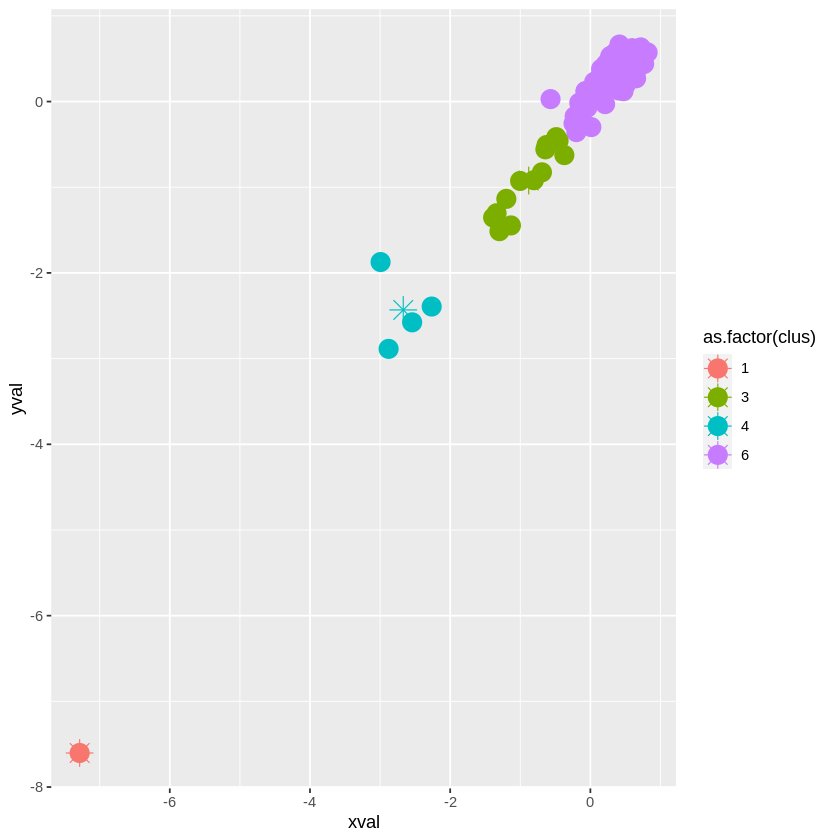

In [ ]:
k_means <- function(x, y, k, random.seed=228) {
  set.seed(random.seed)
  xcen <- runif(n = k, min = min(x), max = max(x))   
  ycen <- runif(n = k, min = min(y), max = max(y))
  data <- data.frame(xval = x, yval = y, clus = NA)
  clus <- data.frame(name = 1:k, xcen = xcen, ycen = ycen)

  finish <- FALSE

  while(finish == FALSE) {
    for(i in 1:length(x)) {
      dist <- sqrt((x[i]-clus$xcen)^2 + (y[i]-clus$ycen)^2)
      data$clus[i] <- which.min(dist)
    }

    xcen_old <- clus$xcen
    ycen_old <- clus$ycen
    for(i in 1:k) {
      clus[i,2] <- mean(subset(data$xval, data$clus == i))
      clus[i,3] <- mean(subset(data$yval, data$clus == i))
    }
    if(identical(xcen_old, clus$xcen) & identical(ycen_old, clus$ycen)) finish <- TRUE
  }
  data
}

cluster <- k_means(normalized_points[,1], normalized_points[,2], k_rough)
cluster.centers <- aggregate(.~clus, cluster, mean)
ggplot(cluster, aes(xval, yval, color = as.factor(clus))) + 
  geom_point(size=5) + 
  geom_point(data=cluster.centers, aes(xval, yval, col=as.factor(clus)), pch=8, size=5)

### 4. Реализуем алгоритм k-medoids. Отобразим полученные кластеры, выделим каждый кластер отдельным цветом, отметим центроиды.



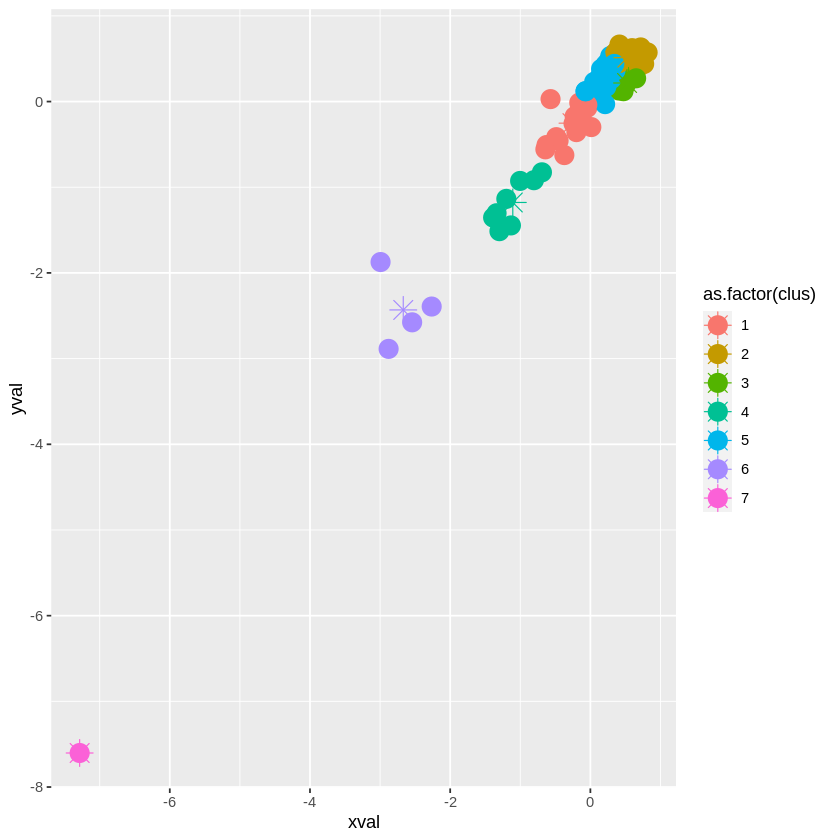

In [ ]:
k_medoids <- function(x, y, k, random.seed=228) {
  set.seed(random.seed)
  xmed <- head(x, k)
  ymed <- head(y, k)
  data <- data.frame(xval = x, yval = y, clus = NA)
  clus <- data.frame(name = 1:k, xmed = xmed, ymed = ymed)

  finish <- FALSE

  while(finish == FALSE) {
    for(i in 1:length(x)) {
      dist <- sqrt((x[i]-clus$xmed)^2 + (y[i]-clus$ymed)^2)
      data$clus[i] <- which.min(dist)
    }

    xmed_old <- clus$xmed
    ymed_old <- clus$ymed

    for(i in 1:k) {
      clus[i,2] <- mean(subset(data$xval, data$clus == i))
      clus[i,3] <- mean(subset(data$yval, data$clus == i))
    }

    if(identical(xmed_old, clus$xmed) & identical(ymed_old, clus$ymed)) finish <- TRUE
  }
  data
}

cluster <- k_medoids(normalized_points[,1], normalized_points[,2], k_rough)
cluster.centers <- aggregate(.~clus, cluster, mean)
ggplot(cluster, aes(xval, yval, color = as.factor(clus))) + 
  geom_point(size=5) + 
  geom_point(data=cluster.centers, aes(xval, yval, col=as.factor(clus)), pch=8, size=5)

## Выводы
В ходе выполнения работы были изучены основы кластеризации. В частности, реализованы методы k-means и k-medoids. Полученные кластеры были отображены графически, их центроиды были выделены. Для них были найдены грубая оценка количества кластеров и оптимальное количество кластеров с помощью метода локтя. 